In [1]:
#%matplotlib widget
from time import time
import numpy as np
import scipy.linalg as sl
import scipy.sparse.linalg as spla
import scipy.sparse as sps
from tabulate import tabulate
from scipy.sparse import diags
import matplotlib.pyplot as plt

import scipy.sparse as sp

In [2]:

def readHB(fname):
    
    global idx,ptrs,vals,rhs
    #fname='matrix.hb'
    f=open(fname,'r')
    
    
    '''
    Line 1 (A72,A8)
    Col. 1 - 72	Title (TITLE)
    Col. 73 - 80	Key (KEY)
    '''
    head = f.readline()
    title=head[:72].strip()
    key=head[72:].strip()

    '''
    Line 2:
    TOTCRD, integer, total number of data lines, (14 characters)
    PTRCRD, integer, number of data lines for pointers, (14 characters)
    INDCRD, integer, number of data lines for row or variable indices, (14 characters)
    VALCRD, integer, number of data lines for numerical values of matrix entries, (14 characters)
    RHSCRD, integer, number of data lines for right hand side vectors, starting guesses, and solutions, (14 characters)
    '''

    s = f.readline().split()
    totcrd = int(s[0])
    ptrcrd = int(s[1])
    indcrd = int(s[2])
    valcrd = int(s[3])
    rhscrd = int(s[4])

    '''
    Line 3:
    MXTYPE, matrix type (see table), (3 characters)
    blank space, (11 characters)
    NROW, integer, number of rows or variables, (14 characters)
    NCOL, integer, number of columns or elements, (14 characters)
    NNZERO, integer, number of row or variable indices. For "assembled" matrices, this is just the number of nonzero entries. (14 characters)
    NELTVL, integer, number of elemental matrix entries. For "assembled" matrices, this is 0. (14 characters)
    '''

    s = f.readline().split()
    mxtype=s[0]
    nrow=int(s[1])
    ncol=int(s[2])
    nnzero=int(s[3])
    neltvl=int(s[4])

    mxf=mxtype[0]
    mxsym=mxtype[1]
    mxasm=mxtype[2]

    '''
    Line 4:
    PTRFMT, FORTRAN I/O format for pointers, (16 characters)
    INDFMT, FORTRAN I/O format for row or variable indices, (16 characters)
    VALFMT, FORTRAN I/O format for matrix entries, (20 characters)
    RHSFMT, FORTRAN I/O format for right hand sides, initial guesses, and solutions, (20 characters)
    '''
    fmts = f.readline().split()


    '''
    Line 5: (only present if 0 < RHSCRD!)
    RHSTYP, describes the right hand side information, (3 characters)
    blank space, (11 characters)
    NRHS, integer, the number of right hand sides, (14 characters)
    NRHSIX, integer, number of row indices, (14 characters)
    '''
    if rhscrd>0:
        s = f.readline().split()
        rhstyp = s[0]
        nrhs=int(s[1])
        nrhsix=int(s[2])



    #    PTRCRD, integer, number of data lines for pointers, (14 characters)

    def readblock(f, num, nlines, dtype=int):
        res=np.zeros(num)
        k=0
        for i in range(nlines):
            s= f.readline().replace('D','E')
            fragment = np.fromstring(s,dtype=dtype,sep=' ')
            l=len(fragment)
            res[k:k+l]=fragment
            k+=l
        return res

    ptrs=readblock(f,nrow+1,ptrcrd)-1

    #INDCRD, integer, number of data lines for row or variable indices, (14 characters)
    idx=readblock(f,nnzero,indcrd)-1

    if mxf == 'C':
        raise ValueError('Complex numbers not supported for now')

    if mxf != 'P':
        #VALCRD, integer, number of data lines for numerical values of matrix entries, (14 characters)
        vals=readblock(f,nnzero,valcrd,dtype=np.float64)
    else:
        vals = np.ones(nnzero)


    #RHSCRD    
    if rhscrd>0:
        rhs = readblock(f,nrow,rhscrd,dtype=np.float64)    


    ''' 
    Each character of the MXTYPE variable specifies a separate fact about the matrix:

    R, C or P indicates that the matrix values are real, complex, or that only the pattern of nonzeroes is going to be supplied. Note that if complex arithmetic is specified, then any data vectors included in the file will also be assumed to be complex. FORTRAN I/O treats a complex number as a simple pair of real numbers. Thus, a line that records the single complex number 12+17i would look like
                12.0  17.0

    U, S, H, Z or R indicates that the matrix is symmetric, unsymmetric, Hermitian, skew symmetric, or rectangular. Each of these facts implies something about how the nonzero elements of the matrix are stored in the file.
    U: if the matrix is unsymmetric (and square), then every nonzero element of the matrix corresponds to an entry in the file.
    S: if the matrix is symmetric (which implies that it is square), (and which typically only occurs for real arithmetic), then half of the nonzero off-diagonal elements don't need to be stored in the file. A user need only specify the diagonal elements, and perhaps just those beneath the diagonal. A program reading the file must, correspondingly, assume that a value associated with one off-diagonal element should also be assigned to its corresponding transposed location.
    H: if the matrix is Hermitian, (which implies that it is square) (and which typically only occurs for complex arithmetic), then half of the nonzero off-diagonal elements don't need to be stored in the file. A user need only specify the diagonal elements, and perhaps just those beneath the diagonal. A program reading the file must, correspondingly, assume that a value associated with one off-diagonal element should also be used to assign a value to its corresponding transposed location.
    Z: if the matrix is skew symmetric, (which implies that it is square) (and which typically only occurs for real arithmetic), then the diagonal is zero, and only half of the nonzero offdiagonal elements need to be stored. (I believe that the Z code is only appropriate for a real matrix, and that the case of a skew Hermitian matrix is not provide for!)
    R: if the matrix is rectangular, then every nonzero element of the matrix must be stored. In effect, this is the same as the unsymmetric case.
    A indicates that the matrix is "assembled" (the typical case) while E indicates that the matrix is a finite element matrix that is going to be described as the "sum" of a set of smaller matrices.
    '''
    
    A=sp.csc_matrix((vals,idx,ptrs),shape=(nrow,ncol))

    if mxsym=='U':
        pass
    if mxsym=='S':
        D=sp.diags(A.diagonal())
        A = A+A.transpose()-D
    if mxsym=='Z':
        A = A-A.transpose()
    if mxsym=='H':
        D=sp.diags(A.diagonal())
        A = A+A.transpose().conj()-D
    print(rhscrd)
    f.close()
    return A

In [3]:
def print_table(results_bicgstab, results_cg, results_jacobi_bicgstab, results_jacobi_cg, results_sgs_bicgstab, results_sgs_cg):
    results_table = [
        ["BICGSTAB", results_bicgstab["preconditioner_time"], results_bicgstab["solver_time"], results_bicgstab["total_time"], results_bicgstab["total_iters"], results_bicgstab["final_relative_residual"]],
        ["CG", results_cg["preconditioner_time"], results_cg["solver_time"], results_cg["total_time"], results_cg["total_iters"], results_cg["final_relative_residual"]],
        ["Jacobi BICGSTAB", results_jacobi_bicgstab["preconditioner_time"], results_jacobi_bicgstab["solver_time"], results_jacobi_bicgstab["total_time"], results_jacobi_bicgstab["total_iters"], results_jacobi_bicgstab["final_relative_residual"]],
        ["Jacobi CG", results_jacobi_cg["preconditioner_time"], results_jacobi_cg["solver_time"], results_jacobi_cg["total_time"], results_jacobi_cg["total_iters"], results_jacobi_cg["final_relative_residual"]],
        ["SGS BICGSTAB", results_sgs_bicgstab["preconditioner_time"], results_sgs_bicgstab["solver_time"], results_sgs_bicgstab["total_time"], results_sgs_bicgstab["total_iters"], results_sgs_bicgstab["final_relative_residual"]],
        ["SGS CG", results_sgs_cg["preconditioner_time"], results_sgs_cg["solver_time"], results_sgs_cg["total_time"], results_sgs_cg["total_iters"],  results_sgs_cg["final_relative_residual"]]
    ]
    headers = ["Solver", "Preconditioner Time (s)", "Solver Time (s)", "Total Time (s)", "Iters", "Final Relative Residual"]
    print(tabulate(results_table, headers=headers, tablefmt="grid"))    

In [4]:
def generate_spd_matrix(n):
    A = np.random.rand(n, n)
    A = np.dot(A, A.T)
    A += n * np.eye(n)
    return A

In [5]:
def create_jacobi_preconditioner(A):
    diag_A = A.diagonal()

    def jacobi_preconditioner(x):
        return x / diag_A

    return spla.LinearOperator(A.shape, matvec=jacobi_preconditioner, dtype=np.float64)


In [6]:
def create_sgs_preconditioner(A):
    n = A.shape[0]
    L = sps.tril(A, -1)
    D = sps.diags(A.diagonal()).tocsr()
    U = sps.triu(A, 1)
    M_L = D + L
    M_U = D + U
    def apply_SGS_preconditioner(r):
        y = spla.spsolve_triangular(M_L, r, lower=True)
        z = spla.spsolve(D, y)
        x = spla.spsolve_triangular(M_U, z, lower=False)
        return x
    
    return spla.LinearOperator(A.shape, matvec=apply_SGS_preconditioner, dtype=np.float64)


In [7]:
A = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
A = sp.csr_matrix(A)
create_sgs_preconditioner(A)

<3x3 _CustomLinearOperator with dtype=float64>

In [8]:
def run_experiment(A, b, solver, preconditioner=None, rtol=1e-4, max_iter=1000):
    residuals = []

    results = {
        "preconditioner_time": None,
        "solver_time": None,
        "total_time": None,
        "total_iters": None,
        "final_relative_residual": None
    }

    initial_residual = np.linalg.norm(b - A @ np.zeros_like(b))
    def callback(xk):
        current_residual = np.linalg.norm(b - A @ xk)
        relative_residual = current_residual / initial_residual
        residuals.append(relative_residual)
    
    if preconditioner is not None:
        print("start_create preconditioner")
        start_time = time()
        M_operator = preconditioner(A)
        end_time = time()
        results["preconditioner_time"] = end_time - start_time
        print("end_create preconditioner")
        start_time = time()
        solver(A, b, rtol=rtol, callback=callback, M=M_operator, maxiter=max_iter)
        end_time = time()
        results["solver_time"] = end_time - start_time
    else:
        results["preconditioner_time"] = 0

        start_time = time()
        solver(A, b, callback=callback, rtol=rtol, maxiter=max_iter)
        end_time = time()
        results["solver_time"] = end_time - start_time
    
    results["total_time"] = results["solver_time"] + results["preconditioner_time"]
    results["total_iters"] = len(residuals)
    results["final_relative_residual"] = residuals[-1] if residuals else None
    
    return residuals, results

In [9]:
n = 1000
max_iter = 1000
A = generate_spd_matrix(n)
A = sp.csr_matrix(A)
b = np.random.rand(n)

In [10]:

residuals_bicgstab, results_bicgstab = run_experiment(A=A, b=b, solver=spla.bicgstab, max_iter=max_iter)
residuals_cg, results_cg  = run_experiment(A=A, b=b, solver=spla.cg, max_iter=max_iter)
residuals_jacobi_bicgstab, results_jacobi_bicgstab = run_experiment(A=A, b=b, solver=spla.bicgstab, preconditioner=create_jacobi_preconditioner, max_iter=max_iter)
residuals_jacobi_cg, results_jacobi_cg  = run_experiment(A=A, b=b, solver=spla.cg, preconditioner=create_jacobi_preconditioner, max_iter=max_iter)
residuals_sgs_bicgstab, results_sgs_bicgstab  = run_experiment(A=A, b=b, solver=spla.bicgstab, preconditioner=create_sgs_preconditioner, max_iter=max_iter)
residuals_sgs_cg, results_sgs_cg  = run_experiment(A=A, b=b, solver=spla.cg, preconditioner=create_sgs_preconditioner, max_iter=max_iter)



start_create preconditioner
end_create preconditioner
start_create preconditioner
end_create preconditioner
start_create preconditioner
end_create preconditioner
start_create preconditioner
end_create preconditioner


In [11]:
print_table(results_bicgstab, results_cg, results_jacobi_bicgstab, results_jacobi_cg, results_sgs_bicgstab, results_sgs_cg)

+-----------------+---------------------------+-------------------+------------------+---------+---------------------------+
| Solver          |   Preconditioner Time (s) |   Solver Time (s) |   Total Time (s) |   Iters |   Final Relative Residual |
+=================+===========================+===================+==================+=========+===========================+
| BICGSTAB        |               0           |        0.00997257 |       0.00997257 |       3 |               3.43269e-05 |
+-----------------+---------------------------+-------------------+------------------+---------+---------------------------+
| CG              |               0           |        0.00997424 |       0.00997424 |       5 |               1.43468e-05 |
+-----------------+---------------------------+-------------------+------------------+---------+---------------------------+
| Jacobi BICGSTAB |               0.000997543 |        0.00897455 |       0.0099721  |       3 |               3.52569e-05 |


In [12]:
plt.figure(figsize=(12, 8))

plt.semilogy(residuals_bicgstab, label='BiCGSTAB без предобуславливателя', marker='o')
plt.semilogy(residuals_cg, label='CG без предобуславливателя', marker='o')
plt.semilogy(residuals_jacobi_bicgstab, label='BiCGSTAB с предобуславливателем Якоби', marker='v')
plt.semilogy(residuals_jacobi_cg, label='CG с предобуславливателем Якоби', marker='v')
plt.semilogy(residuals_sgs_bicgstab, label='BiCGSTAB с предобуславливателем sgs', marker='x')
plt.semilogy(residuals_sgs_cg, label='CG с предобуславливателем sgs', marker='x')

plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('Невязка')
plt.title('Сравнение уменьшения невязок для различных методов и предобуславливателей')
plt.legend()

#plt.tight_layout()
plt.show()


In [13]:
A = readHB('MATRIX.DAT')
A = sp.csr_matrix(A)
n = A.shape[0]
x0=np.random.rand(n)
b = A.dot(x0)

18046


In [14]:
residuals_bicgstab, results_bicgstab = run_experiment(A=A, b=b, solver=spla.bicgstab, max_iter=max_iter)
print('BiCGSTAB без предобуславливателя закончил')

residuals_cg, results_cg = run_experiment(A=A, b=b, solver=spla.cg, max_iter=max_iter)
print('CG без предобуславливателя закончил')

residuals_jacobi_bicgstab, results_jacobi_bicgstab = run_experiment(A=A, b=b, solver=spla.bicgstab, preconditioner=create_jacobi_preconditioner, max_iter=max_iter)
print('BiCGSTAB с предобуславливателем Якоби закончил')

residuals_jacobi_cg, results_jacobi_cg = run_experiment(A=A, b=b, solver=spla.cg, preconditioner=create_jacobi_preconditioner, max_iter=max_iter)
print('CG с предобуславливателем Якоби закончил')


residuals_sgs_bicgstab, results_sgs_bicgstab = run_experiment(A=A, b=b, solver=spla.bicgstab, preconditioner=create_sgs_preconditioner, max_iter=max_iter)
print('BiCGSTAB с предобуславливателем sgs закончил')

residuals_sgs_cg, results_sgs_cg = run_experiment(A=A, b=b, solver=spla.cg, preconditioner=create_sgs_preconditioner, max_iter=max_iter)
print('CG с предобуславливателем sgs закончил')

print_table(results_bicgstab, results_cg, results_jacobi_bicgstab, results_jacobi_cg, results_sgs_bicgstab, results_sgs_cg)

BiCGSTAB без предобуславливателя закончил
CG без предобуславливателя закончил
start_create preconditioner
end_create preconditioner
BiCGSTAB с предобуславливателем Якоби закончил
start_create preconditioner
end_create preconditioner
CG с предобуславливателем Якоби закончил
start_create preconditioner
end_create preconditioner
BiCGSTAB с предобуславливателем sgs закончил
start_create preconditioner
end_create preconditioner
CG с предобуславливателем sgs закончил
+-----------------+---------------------------+-------------------+------------------+---------+---------------------------+
| Solver          |   Preconditioner Time (s) |   Solver Time (s) |   Total Time (s) |   Iters |   Final Relative Residual |
+=================+===========================+===================+==================+=========+===========================+
| BICGSTAB        |               0           |         0.107211  |         0.107211 |     107 |               9.90448e-05 |
+-----------------+---------------

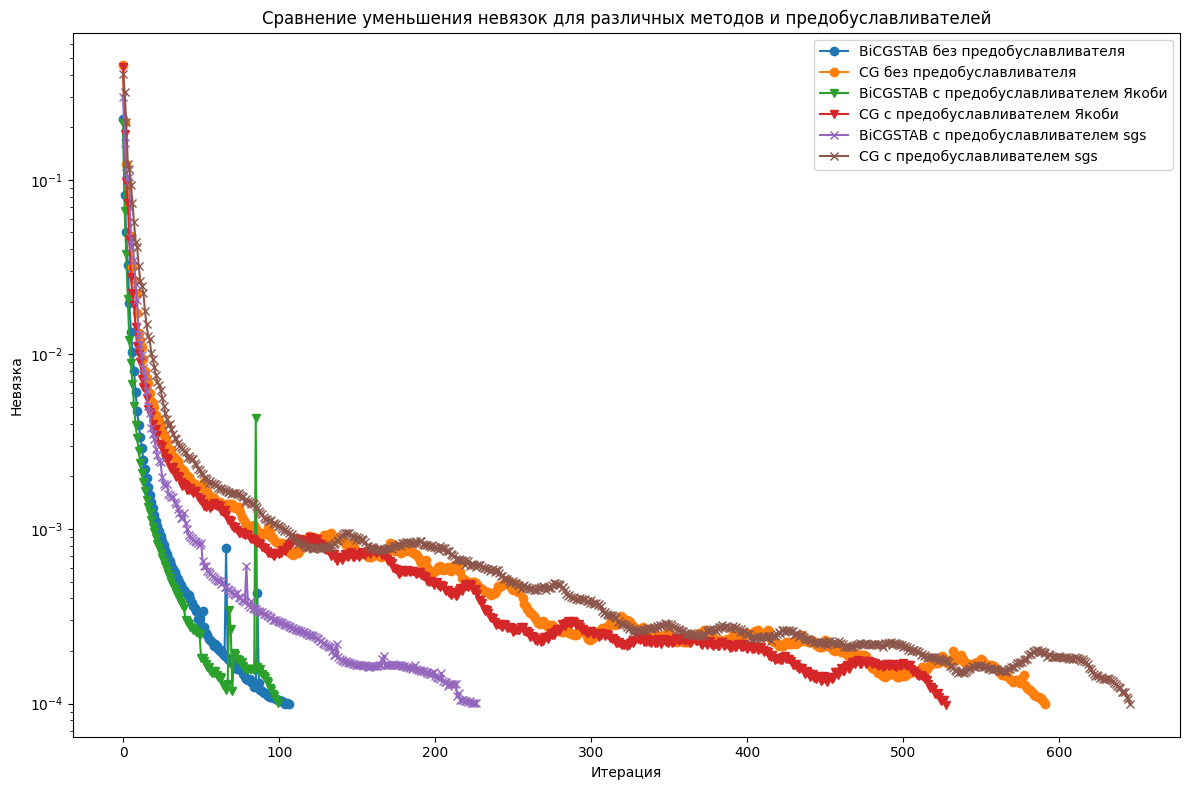

In [15]:
plt.figure(figsize=(12, 8))

plt.semilogy(residuals_bicgstab, label='BiCGSTAB без предобуславливателя', marker='o')
plt.semilogy(residuals_cg, label='CG без предобуславливателя', marker='o')
plt.semilogy(residuals_jacobi_bicgstab, label='BiCGSTAB с предобуславливателем Якоби', marker='v')
plt.semilogy(residuals_jacobi_cg, label='CG с предобуславливателем Якоби', marker='v')
plt.semilogy(residuals_sgs_bicgstab, label='BiCGSTAB с предобуславливателем sgs', marker='x')
plt.semilogy(residuals_sgs_cg, label='CG с предобуславливателем sgs', marker='x')

plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('Невязка')
plt.title('Сравнение уменьшения невязок для различных методов и предобуславливателей')
plt.legend()

plt.tight_layout()
plt.show()